In [ ]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl 
!pip3 install torchvision

In [ ]:
import torch
print(torch.__version__)
print(accelerator)
print(torch.cuda.is_available())

0.4.0
cu80
True


# 1. Датасет с логотипами с сайта по ссылке ниже


In [ ]:
import urllib.request
import os
import zipfile
import shutil
from pathlib import Path

In [ ]:
# See download section on URL: http://www.multimedia-computing.de/flickrlogos/
FLICKLOGOS_URL = <...FlickrLogos-32_dataset_v2.zip>

In [ ]:
SOURCE_DIR = Path('FlickrLogos-v2')
DATA_DIR = Path('data')
SETS = ['train', 'val', 'test']

In [ ]:
def load_datasets(url, dst_dir):
    zip_file = url.split(sep='/')[-1]
    zip_file_path = SOURCE_DIR / zip_file
    if not dst_dir.is_dir():
        if not zip_file_path.is_file():
            urllib.request.urlretrieve(url, zip_file)        
        with zipfile.ZipFile(zip_file) as zip_ref:
            zip_ref.extractall()
        #os.unlink(zip_file)    # comment out if you want to delete zip file

In [ ]:
%time load_datasets(FLICKLOGOS_URL, SOURCE_DIR)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 750 µs


In [ ]:
!ls FlickrLogos-v2

all.filenames.txt		 trainset.relpaths.txt
all.relpaths.txt		 trainset.spaces.txt
all.spaces.txt			 trainset.txt
all.txt				 trainvalset.filenames.txt
classes				 trainvalset.relpaths.txt
README.txt			 trainvalset.spaces.txt
scripts				 trainvalset.txt
testset.filenames.txt		 valset.filenames.txt
testset-logosonly.filenames.txt  valset-logosonly.filenames.txt
testset-logosonly.relpaths.txt	 valset-logosonly.relpaths.txt
testset-logosonly.spaces.txt	 valset-logosonly.spaces.txt
testset-logosonly.txt		 valset-nologos.filenames.txt
testset-nologos.filenames.txt	 valset-nologos.relpaths.txt
testset-nologos.relpaths.txt	 valset-nologos.spaces.txt
testset-nologos.spaces.txt	 valset.relpaths.txt
testset.relpaths.txt		 valset.spaces.txt
testset.spaces.txt		 valset.txt
testset.txt			 visualsummary.jpg
trainset.filenames.txt


# 2. Разделение данных и подготовка к обработке

In [ ]:
def list_image_paths(txt_relpath):
    with open(txt_relpath) as f:
        image_paths = f.read().splitlines()
    return image_paths

In [ ]:
train_logo_relpaths = list_image_paths(SOURCE_DIR / 'trainset.relpaths.txt')
val_logo_relpaths = list_image_paths(SOURCE_DIR / 'valset-logosonly.relpaths.txt')
val_nologo_relpaths = list_image_paths(SOURCE_DIR / 'valset-nologos.relpaths.txt')
test_relpaths = list_image_paths(SOURCE_DIR / 'testset.relpaths.txt')

In [ ]:
print('Numbers of Training Images (logo): ',len(train_logo_relpaths))
print('Numbers of Validation Images (logo): ',len(val_logo_relpaths))
print('Numbers of Training Images (no logo): ',len(val_nologo_relpaths))
print('Numbers of Test Images (logos + no log): ',len(test_relpaths))

Numbers of Training Images (logo):  320
Numbers of Validation Images (logo):  960
Numbers of Training Images (no logo):  3000
Numbers of Test Images (logos + no log):  3960


In [ ]:
train_relpaths = train_logo_relpaths + val_nologo_relpaths[:int(len(val_nologo_relpaths) / 2)]
val_relpaths = val_logo_relpaths + val_nologo_relpaths[int(len(val_nologo_relpaths) / 2):]

In [ ]:
print('Numbers of Training Images (logos + no logo): ',len(train_relpaths))
print('Numbers of Validation Images (logos + no logo): ',len(val_relpaths))
print('Numbers of Training Images (logos + no log): ',len(test_relpaths))

Numbers of Training Images (logos + no logo):  1820
Numbers of Validation Images (logos + no logo):  2460
Numbers of Training Images (logos + no log):  3960


In [ ]:
relpaths = [train_relpaths, val_relpaths, test_relpaths]
dataset_paths = dict(zip(SETS, relpaths))

In [ ]:
len(dataset_paths['train'])

1820

In [ ]:
train_logo_relpaths[0]

'classes/jpg/google/2325670467.jpg'

In [ ]:
def prepare_datasets(src_dir, dst_dir, keep_source=True):
    for dataset, paths in dataset_paths.items():
        num_files = 0
        for path in paths:
            num_files += 1
            src = src_dir / path
            dst = dst_dir / (path.replace('classes/jpg', dataset))
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
        print(dataset, 'dataset:', str(num_files))
    if not keep_source: shutil.rmtree(src_dir)

In [ ]:
!ls data

test  train  val


In [ ]:
%time prepare_datasets(SOURCE_DIR, DATA_DIR)

train dataset: 1820
val dataset: 2460
test dataset: 3960
CPU times: user 3.25 s, sys: 6.09 s, total: 9.34 s
Wall time: 45.6 s


## DataLoader

In [ ]:
%matplotlib inline
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [ ]:
train_mean = np.array([0.44943, 0.4331 , 0.40244])
train_std = np.array([0.29053, 0.28417, 0.30194])

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [ ]:
datasets = {i : torchvision.datasets.ImageFolder(DATA_DIR / i, data_transforms) 
            for i in SETS}

In [ ]:
bz = 8 # lower if error

In [ ]:
dataloaders = {i : DataLoader(datasets[i], batch_size=bz, shuffle=(i == 'train'), num_workers=4) 
               for i in SETS}

## Visualize Datasets

In [ ]:
def imshow(img):
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = npimg * train_std + train_std    # denorm
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

no-logo, no-logo, singha, no-logo


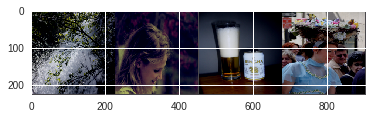

In [ ]:
img = torchvision.utils.make_grid(imgs[:4])
classes = datasets['train'].classes
print(', '.join(classes[i] for i in labels[:4]))
imshow(img)

# Архитектура используемой модели(копия AlexNet)

<img src="https://pytorch.org/tutorials/_images/mnist.png">

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 33)        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cnn = CNN()
cnn = cnn.to(device)
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
)

## Функция потерь и оптимайзер

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

## Фукция обучения и валидация качества

In [ ]:
def train_val(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoc {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
            
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Compute loss
                    loss = criterion(outputs, labels)

                    # Compute gradients and update parameters if train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])
        
            print('{} Loss: {:.4f} Acc.: {:.2f} %'.format(
                phase.title(), epoch_loss, epoch_acc * 100))
        
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy: {:.2f} %'.format(best_acc * 100))
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
%time model_cnn = train_val(cnn, criterion, optimizer)

Epoc 0/24
----------
Train Loss: 1.2789 Acc.: 81.10 %
Val Loss: 2.0824 Acc.: 60.98 %

Epoc 1/24
----------
Train Loss: 1.0940 Acc.: 82.42 %
Val Loss: 1.9814 Acc.: 60.98 %

Epoc 2/24
----------
Train Loss: 1.0444 Acc.: 82.42 %
Val Loss: 2.0759 Acc.: 60.98 %

Epoc 3/24
----------
Train Loss: 0.9732 Acc.: 82.42 %
Val Loss: 2.3913 Acc.: 60.98 %

Epoc 4/24
----------
Train Loss: 0.9207 Acc.: 82.42 %
Val Loss: 2.3195 Acc.: 60.98 %

Epoc 5/24
----------
Train Loss: 0.9183 Acc.: 82.42 %
Val Loss: 2.3083 Acc.: 60.98 %

Epoc 6/24
----------
Train Loss: 0.8030 Acc.: 82.64 %
Val Loss: 2.2799 Acc.: 60.93 %

Epoc 7/24
----------
Train Loss: 0.6595 Acc.: 84.56 %
Val Loss: 2.4849 Acc.: 61.34 %

Epoc 8/24
----------
Train Loss: 0.5301 Acc.: 87.47 %
Val Loss: 2.8844 Acc.: 61.46 %

Epoc 9/24
----------
Train Loss: 0.3071 Acc.: 92.97 %
Val Loss: 4.1787 Acc.: 61.63 %

Epoc 10/24
----------
Train Loss: 0.1394 Acc.: 96.65 %
Val Loss: 3.5563 Acc.: 58.13 %

Epoc 11/24
----------
Train Loss: 0.1170 Acc.: 97.03 

# Запуск на тесте

In [ ]:
def test(model):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels).item()
        
    test_acc = running_corrects / len(datasets['test'])
    print('Test Acc.: {:.2f} %'.format(test_acc * 100))

In [ ]:
%time test(model_cnn)

Test Acc.: 75.68 %
CPU times: user 3.62 s, sys: 1.69 s, total: 5.31 s
Wall time: 2min 15s
